In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('output_keystroke.csv')
df2 = pd.read_csv('output_touch_gesture.csv')



In [19]:
keyboard_open = input("Is the keyboard currently open? (yes/no): ").strip().lower()
use_keystroke = keyboard_open == 'yes'

print("\n" + "="*50)
if use_keystroke:
    print("🚀 Launching Keystroke Authentication System")
    df = df1
else:
    print("👆 Launching Touch Gesture Authentication System")
    df = df2
print("="*50 + "\n")


🚀 Launching Keystroke Authentication System



🔧 Creating Keystroke sequences...
✅ Created 470066 sequences of length 20
🧩 Creating training pairs...
📊 Train/Test split: 3200 train, 800 test
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 20, 3)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 20, 3)]      0           []                               
                                                                                                  
 model_6 (Functional)           (None, 64)           17408       ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                               

c:\Users\88019\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


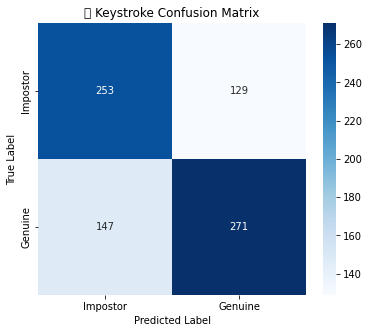

c:\Users\88019\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


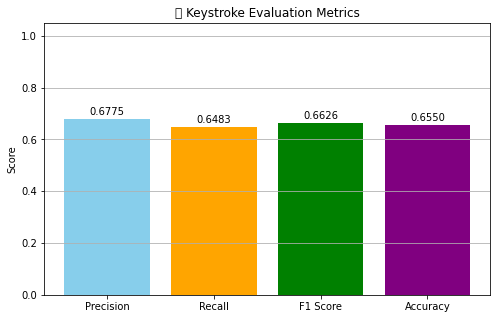

c:\Users\88019\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


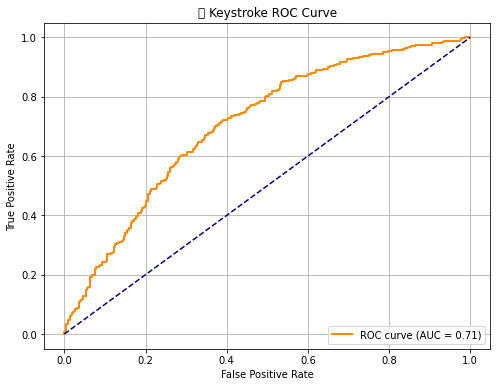


🔍 Testing with Synthetic Sequence for User 13...
165/165 [==============================] - 2s 5ms/step

Test similarity scores with user 13:
Sample 1: 22.34% → ❌ Not a match
Sample 2: 21.36% → ❌ Not a match
Sample 3: 20.61% → ❌ Not a match
Sample 4: 21.57% → ❌ Not a match
Sample 5: 21.43% → ❌ Not a match
Sample 6: 18.17% → ❌ Not a match
Sample 7: 20.51% → ❌ Not a match
Sample 8: 21.11% → ❌ Not a match
Sample 9: 20.48% → ❌ Not a match
Sample 10: 22.78% → ❌ Not a match
Sample 11: 22.10% → ❌ Not a match
Sample 12: 22.45% → ❌ Not a match
Sample 13: 21.69% → ❌ Not a match
Sample 14: 19.87% → ❌ Not a match
Sample 15: 22.42% → ❌ Not a match
Sample 16: 19.90% → ❌ Not a match
Sample 17: 18.40% → ❌ Not a match
Sample 18: 19.66% → ❌ Not a match
Sample 19: 18.38% → ❌ Not a match
Sample 20: 19.59% → ❌ Not a match
Sample 21: 19.56% → ❌ Not a match
Sample 22: 17.72% → ❌ Not a match
Sample 23: 16.96% → ❌ Not a match
Sample 24: 19.64% → ❌ Not a match
Sample 25: 23.73% → ❌ Not a match
Sample 26: 23.21

c:\Users\88019\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


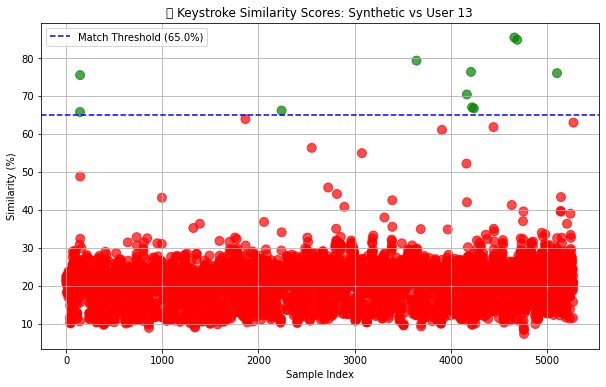

In [20]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    accuracy_score, roc_curve, auc
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences

# =============================================================================
# CONFIGURATION
# =============================================================================
SEQUENCE_LENGTH = 20

if use_keystroke:
    model_type = "Keystroke"
    features = ['keystroke_hold_time', 'keystroke_release_time', 'Key_encoded']
    feature_ranges = {
        'keystroke_hold_time': (-1.424158e+00, 3.809274e+06),
        'keystroke_release_time': (-4.911940e+04, 7.053902e+06),
        'Key_encoded': (0.000000e+00, 8.500000e+01),
    }
    epochs = 20
    target_user = 13
else:
    model_type = "Touch Gesture"
    features = ['Xvalue', 'Yvalue', 'touchMajor', 'touchMinor', 'actionType', 'Gesture_time_diff']
    feature_ranges = {
        'Xvalue': (-1.334735e+00, 9.776609e-01),
        'Yvalue': (-2.158944e+00, 3.356786e+00),
        'touchMajor': (-1.051641e+00, 1.853282e+00),
        'touchMinor': (-9.874038e-01, 1.791463e+00),
        'actionType': (0.000000e+00, 2.620000e+02),
        'Gesture_time_diff': (-9.545921e+07, 6.136795e+08),
    }
    epochs = 16
    target_user = 52

# =============================================================================
# SEQUENCE CREATION
# =============================================================================
def create_sequences(df, features, user_col='user'):
    sequences = []
    labels = []
    for user_id, user_group in df.groupby(user_col):
        user_data = user_group[features].values
        for i in range(0, len(user_data) - SEQUENCE_LENGTH + 1):
            seq = user_data[i:i + SEQUENCE_LENGTH]
            sequences.append(seq)
            labels.append(user_id)
    return np.array(sequences), np.array(labels)

print(f"🔧 Creating {model_type} sequences...")
X, y = create_sequences(df, features)
print(f"✅ Created {len(X)} sequences of length {SEQUENCE_LENGTH}")

# =============================================================================
# DATA PREPARATION
# =============================================================================
user_sequences = {}
for user_id in np.unique(y):
    user_indices = np.where(y == user_id)[0]
    if len(user_indices) >= 2:  # Only include users with at least 2 sequences
        user_sequences[user_id] = X[user_indices]

def create_pairs(user_sequences, max_pairs=1000):
    pairs = []
    labels = []
    users = list(user_sequences.keys())

    for _ in range(max_pairs):
        # Positive pair (same user)
        user = random.choice(users)
        seqs = user_sequences[user]
        if len(seqs) >= 2:
            a, b = random.sample(seqs.tolist(), 2)
            pairs.append([a, b])
            labels.append(1)

        # Negative pair (different users)
        user1, user2 = random.sample(users, 2)
        a = random.choice(user_sequences[user1])
        b = random.choice(user_sequences[user2])
        pairs.append([a, b])
        labels.append(0)

    return np.array(pairs), np.array(labels)

print("🧩 Creating training pairs...")
pairs, labels = create_pairs(user_sequences, max_pairs=2000)

# Prepare input data
X1 = np.array([p[0] for p in pairs])
X2 = np.array([p[1] for p in pairs])

# Split data
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, labels, test_size=0.2, random_state=42
)
print(f"📊 Train/Test split: {len(X1_train)} train, {len(X1_test)} test")

# =============================================================================
# SIAMESE LSTM MODEL
# =============================================================================
input_shape = (SEQUENCE_LENGTH, len(features))

def build_lstm_branch(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64)(inp)
    return Model(inputs=inp, outputs=x)

lstm_branch = build_lstm_branch(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

encoded_a = lstm_branch(input_a)
encoded_b = lstm_branch(input_b)

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_a, encoded_b])

output = Dense(1, activation='sigmoid')(L1_distance)

model = Model(inputs=[input_a, input_b], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

# =============================================================================
# MODEL TRAINING
# =============================================================================
print(f"\n🔥 Training {model_type} Model for {epochs} epochs...")
history = model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_test, X2_test], y_test),
    epochs=epochs,
    batch_size=32,
    verbose=1
)

# Save model
model_save_name = f'siamese_lstm_model_{"keystroke" if use_keystroke else "touch"}.h5'
model.save(model_save_name)
print(f"✅ Model saved as {model_save_name}")

# =============================================================================
# EVALUATION METRICS
# =============================================================================
# Predictions
y_pred_prob = model.predict([X1_test, X2_test])
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_class, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Impostor', 'Genuine'], 
            yticklabels=['Impostor', 'Genuine'])
plt.title(f'🔲 {model_type} Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Metrics summary
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)

# Metrics visualization
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision, recall, f1, accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylim(0, 1.05)
plt.title(f'📊 {model_type} Evaluation Metrics')
plt.ylabel('Score')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, 
             f'{yval:.4f}', ha='center', va='bottom')
plt.grid(axis='y')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'📈 {model_type} ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# =============================================================================
# SYNTHETIC TEST SEQUENCE MATCHING
# =============================================================================
print(f"\n🔍 Testing with Synthetic Sequence for User {target_user}...")

if target_user not in user_sequences:
    print(f"⚠️ Target user {target_user} not found in sequences. Selecting random user.")
    target_user = random.choice(list(user_sequences.keys()))
    print(f"🎯 New target user: {target_user}")

user_samples = user_sequences[target_user]

# Generate random sequence
random_sequence = np.array([
    [np.random.uniform(low, high) for (low, high) in feature_ranges.values()]
    for _ in range(SEQUENCE_LENGTH)
], dtype='float32')

# Prepare test batch
test_batch = np.repeat(random_sequence[None, :], len(user_samples), axis=0)

# Calculate similarities
similarities = model.predict([test_batch, user_samples])
percentages = similarities.flatten() * 100

# Match results
match_threshold = 65.00
match_count = sum(p >= match_threshold for p in percentages)

print(f"\nTest similarity scores with user {target_user}:")
for i, p in enumerate(percentages):
    verdict = "✅ Match" if p >= match_threshold else "❌ Not a match"
    print(f"Sample {i+1}: {p:.2f}% → {verdict}")

print("\n📋 Summary Report:")
print(f"Total samples compared: {len(percentages)}")
print(f"Matches found: {match_count}")
print(f"Match threshold: {match_threshold:.2f}%")
print(f"Match rate: {match_count/len(percentages)*100:.2f}%")

# Visualize similarity scores
plt.figure(figsize=(10, 6))
colors = ['green' if p >= match_threshold else 'red' for p in percentages]
plt.scatter(range(len(percentages)), percentages, c=colors, alpha=0.7, s=80)
plt.axhline(match_threshold, color='blue', linestyle='--', 
            label=f'Match Threshold ({match_threshold}%)')
plt.title(f'🔍 {model_type} Similarity Scores: Synthetic vs User {target_user}')
plt.xlabel('Sample Index')
plt.ylabel('Similarity (%)')
plt.legend()
plt.grid(True)
plt.show()